In [1]:
import pandas as pd 
import numpy as np
import re
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as offline
import plotly.graph_objs as go
init_notebook_mode()

pd.options.display.max_columns = 100

# Load Data

In [912]:
df = pd.read_csv('traffic.csv')

In [913]:
df.shape

(1196940, 28)

In [914]:
df.head(2)

,borough,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,cross_street_name,timestamp,latitude,longitude,location,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_persons_injured,number_of_persons_killed,off_street_name,on_street_name,unique_key,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,zip_code
0,NaN,Other Vehicular,Aggressive Driving/Road Rage,Aggressive Driving/Road Rage,Aggressive Driving/Road Rage,Unspecified,NaN,2013-09-29 14:20:00 UTC,40.811903,-73.966247,"(40.8119031, -73.9662468)",0,0,4,0,0,0,4,0,NaN,NaN,2866574,PASSENGER VEHICLE,MOTORCYCLE,MOTORCYCLE,MOTORCYCLE,MOTORCYCLE,NaN
1,NaN,Brakes Defective,Unspecified,NaN,NaN,NaN,NaN,2017-04-07 15:48:00 UTC,40.840090,-73.880360,"(40.84009, -73.88036)",0,0,6,0,0,0,6,0,NaN,BOSTON ROAD,3647766,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN


In [5]:
# determine percentage of null values for each field 
(df.isnull().sum()/df.shape[0]).sort_values(ascending = False)

vehicle_type_code_5              0.996659
contributing_factor_vehicle_5    0.996553
vehicle_type_code_4              0.986556
contributing_factor_vehicle_4    0.986041
vehicle_type_code_3              0.937130
contributing_factor_vehicle_3    0.935119
off_street_name                  0.898433
zip_code                         0.283829
borough                          0.283717
cross_street_name                0.272471
on_street_name                   0.216464
longitude                        0.178957
location                         0.178957
latitude                         0.178957
vehicle_type_code2               0.162625
contributing_factor_vehicle_2    0.136464
vehicle_type_code1               0.007622
contributing_factor_vehicle_1    0.004725
timestamp                        0.000000
unique_key                       0.000000
number_of_persons_killed         0.000000
number_of_persons_injured        0.000000
number_of_cyclist_injured        0.000000
number_of_cyclist_killed         0

# Data Cleaning

## Transform Dates

In [6]:
import datetime
import pytz

In [7]:
dates_map = df[['timestamp']].drop_duplicates()

In [8]:
dates_map['dt'] = pd.to_datetime(dates_map['timestamp'])

In [9]:
def convert_tz(cell):
    old = pytz.timezone('UTC')
    new = pytz.timezone('US/Eastern')
    
    return old.localize(pd.to_datetime(cell)).astimezone(new).strftime("%Y-%m-%d %H:%M:%S")    

In [10]:
dates_map['dt_eastern'] = pd.to_datetime(dates_map['dt'].apply(lambda x: convert_tz(x)))

In [11]:
# extract datetime elements
dates_map['year'] = dates_map['dt_eastern'].apply(lambda x: x.year)
dates_map['month'] = dates_map['dt_eastern'].apply(lambda x: x.month)
dates_map['date'] = dates_map['dt_eastern'].apply(lambda x: x.date())
dates_map['hour'] = dates_map['dt_eastern'].apply(lambda x: x.hour)
dates_map['week'] = dates_map['dt_eastern'].apply(lambda x: x.weekday())
dates_map['weekend'] = dates_map['dt_eastern'].apply(lambda x: 1 if x.weekday() > 4 else 0)

In [12]:
df = pd.merge(df, dates_map, on = 'timestamp')

In [13]:
# remove incomplete data from 2012, 2018
data = df[(df['year'] > 2012) & (df['year'] < 2018)]
del df

## Fill Missing Geo Data

In [14]:
# filter to rows where borough and zip are null but location is not --> get unique locations
nulls = data[(data['borough'].isnull() | data['zip_code'].isnull()) & (data['location'].notnull())][['location']].drop_duplicates()

In [15]:
pre = data[data['borough'].notnull() & (data['location'].isin(nulls['location']))].\
groupby(['location', 'borough', 'zip_code']).size().rename('c').reset_index()

pre = pre.sort_values(['location', 'borough', 'c', 'zip_code'], ascending = [False, False, False, False])

# find locations that already exist in the dataset
loc_map1 = pre.groupby(['location']).first().reset_index()

In [16]:
# location that need to be searched using API
loc_map2 = nulls[~nulls['location'].isin(loc_map1['location'])]

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

locs = data[data['location'].isin(loc_map2['location'])].location.value_counts().reset_index()
locs.columns = ['location', 'counts']

loc_dict = {}

loca = re.compile(r'\(([^)]+)')
for loc in locs['location'][0:1000]:
    coord = geolocator.reverse(loca.findall(loc)[0])
    loc_dict[loc] = coord.address
    print loc

In [ ]:
def get_info(cell, regexp):
    try:
        return regexp.findall(cell)[0]
    except:
        pass

borough = re.compile(r'Manhattan|Brooklyn|Bronx|Queens|Staten Island|Kings|Richmond')
zipcode = re.compile(r'([0-9]{5})')

ld = pd.DataFrame(data = loc_dict.items(), columns = ['location', 'address'])
ld['bor'] = ld['address'].apply(lambda x: get_info(x, borough))
ld['zip_code'] = ld['address'].apply(lambda x: get_info(x, zipcode))

In [18]:
# ld = pd.read_csv('loc_map.csv', sep = '|', encoding = 'utf-8')
# ld = ld.rename(columns = {'zip':'zip_code'})

In [21]:
ld.loc[:, 'borough'] = ld['bor']

ld.loc[ld['bor'] == 'Kings', 'borough'] = 'Brooklyn'
ld.loc[ld['bor'] == 'Richmond', 'borough'] = 'Queens'
ld['bor'] = ld['bor'].str.upper()

In [22]:
loc_map = pd.concat([loc_map1[['location', 'borough', 'zip_code']], ld[['location', 'borough', 'zip_code']]], axis = 0)
loc_map.columns = ['location', 'bor', 'zip']

In [25]:
data = pd.merge(data, loc_map, on = 'location', how = 'left')

data.loc[data['borough'].isnull(), 'borough'] = data['bor']
data.loc[data['zip_code'].isnull(), 'zip_code'] = data['zip']

# Data Exploration

## Time Series 

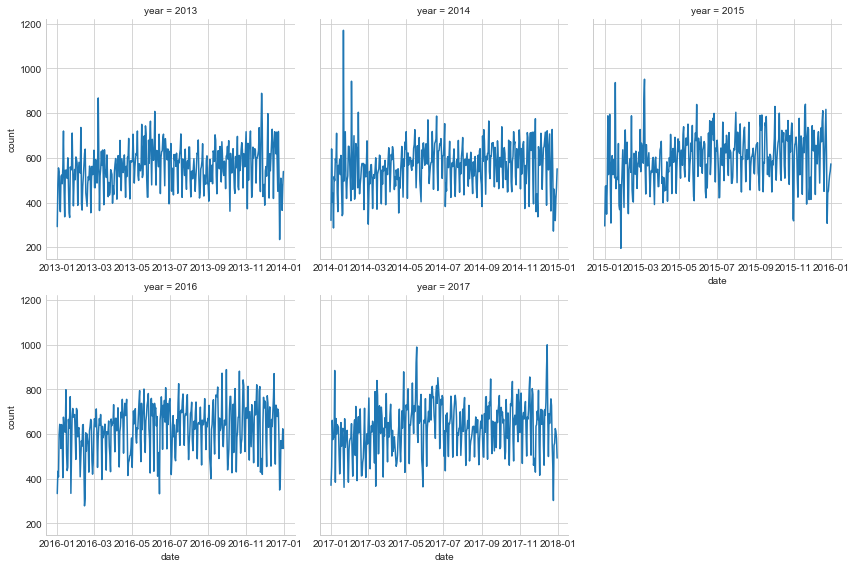

In [294]:
# accidents by year 
date_counts = data.groupby(['year', 'date']).size().rename('count').reset_index()

g = sns.FacetGrid(date_counts, col = 'year', sharex = False, col_wrap = 3, size = 4)
g = g.map(plt.plot, 'date', 'count')

In [106]:
data['yearmon'] = pd.to_datetime(data[['year', 'month']].assign(day = 1))

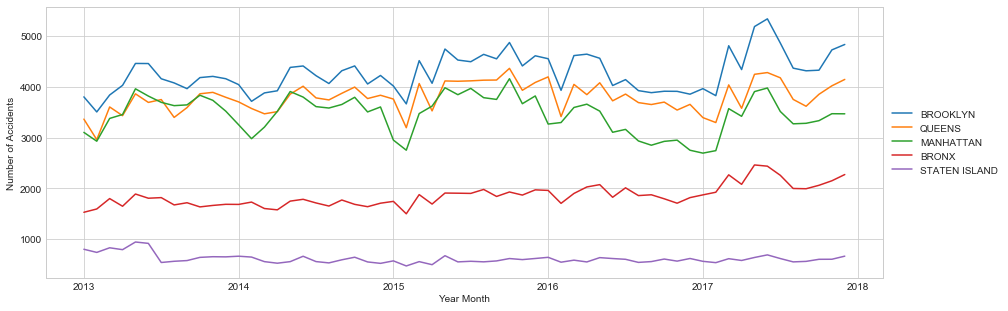

In [510]:
# accidents by year by borough 
fig, ax = plt.subplots()
for bor in data.borough.value_counts().index:
    data[data['borough'] == bor].groupby('yearmon').size().plot(figsize = (15, 5), label = bor)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Year Month')
    plt.ylabel('Number of Accidents')

In [134]:
data['num_fatality'] = data['number_of_persons_injured'] + data['number_of_persons_killed']
data['fatality'] = data['num_fatality'].apply(lambda x: 1 if x > 0 else 0)

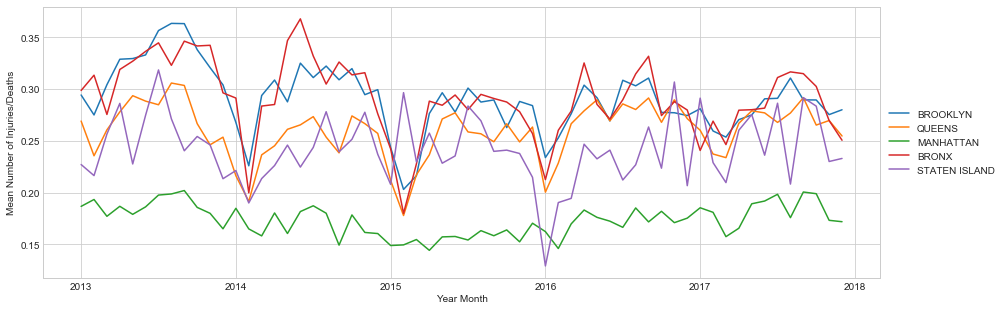

In [511]:
# mean fatality by year by borough 
fig, ax = plt.subplots()
for bor in data.borough.value_counts().index:
    data[data['borough'] == bor].groupby('yearmon').num_fatality.mean().plot(figsize = (15, 5), label = bor)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Year Month')
    plt.ylabel('Mean Number of Injuries/Deaths')

In [953]:
bor_accs = data.groupby(['borough','yearmon']).size().rename('accs').reset_index()
bor_fats = data.groupby(['borough','yearmon']).num_fatality.mean().rename('mean_fats').reset_index()
bor_accs_fats = pd.merge(bor_accs, bor_fats, on = ['borough', 'yearmon'])

In [958]:
bor_accs_fats[['accs', 'mean_fats']].corr()

,accs,mean_fats
accs,1.000000,-0.008187
mean_fats,-0.008187,1.000000


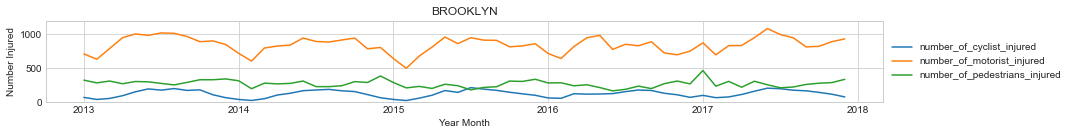

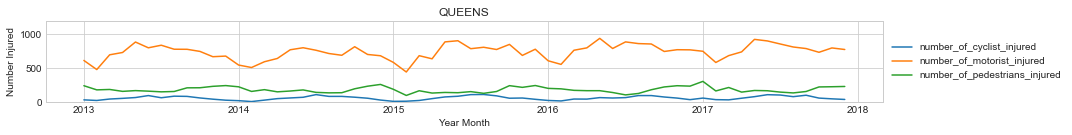

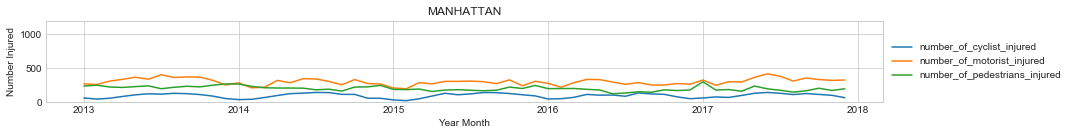

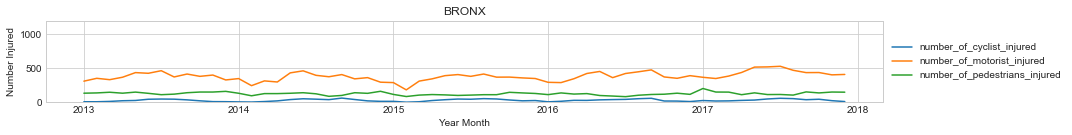

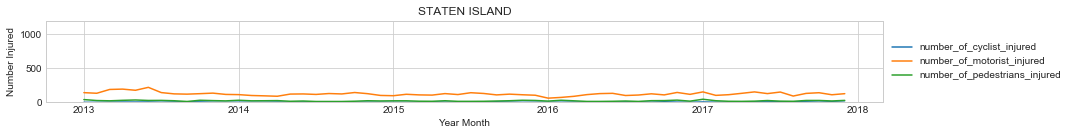

In [540]:
# types of accidents by borough
for bor in data.borough.value_counts().index:
    fig, ax = plt.subplots(figsize = (15, 1.5))
    data[data['borough'] == bor].groupby('yearmon').number_of_cyclist_injured.sum().plot()
    data[data['borough'] == bor].groupby('yearmon').number_of_motorist_injured.sum().plot()
    data[data['borough'] == bor].groupby('yearmon').number_of_pedestrians_injured.sum().plot()
    
    plt.title(bor)
    plt.xlabel('Year Month')
    plt.ylabel('Number Injured')
    plt.xlabel('Year Month')
    plt.legend()
    plt.ylim(0, 1200)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [823]:
# bubble plot of accident count, time, number of fatalities, perc of fatalities from accidents

accs = data.groupby(['borough', 'yearmon']).size().rename('count').reset_index()
percs = data.groupby(['borough', 'yearmon', 'fatality']).size().groupby(level = [0, 1]).\
apply(lambda x: x / x.sum()).rename('perc').reset_index()
fatals = data.groupby(['borough', 'yearmon'])['num_fatality'].sum().rename('fatal').reset_index()

bubble = pd.merge(accs, percs[percs['fatality'] == 1], on = ['borough', 'yearmon'])
bubble = pd.merge(bubble, fatals, on = ['borough', 'yearmon'])

In [944]:
bor = 'BRONX'
df = bubble[bubble['borough'] == bor]
df.loc[:, 'text'] = df.apply(lambda x: 'Num Fatalities: {}<br>Perc Fatalities: {}'.format(x.fatal, round(x.perc, 2)), axis = 1)

trace0 = go.Scatter(
    x = df['yearmon'],
    y = df['count'],
    mode = 'markers',
    marker = dict(
        color = df['perc'],
        sizemode = 'area',
        size = df['fatal'],
        showscale = True
    ),
    text = df['text']
)

layout = go.Layout(
    title = '{} Accident Trends Over Time'.format(bor),
    xaxis = dict(title = 'Year Month'),
    yaxis = dict(title = 'Number of Accidents')
)

fig = go.Figure(data = [trace0], layout = layout)
iplot(fig)

# Data Analysis

## Accident Causes

In [524]:
# get top causes to bucket
causes = data.contributing_factor_vehicle_1.value_counts().cumsum()/data.shape[0]
top_causes = causes[causes <= 0.99].index

data.loc[:, 'causes'] = data['contributing_factor_vehicle_1']
data.loc[~data['causes'].isin(top_causes), 'causes'] = 'Other'

In [526]:
data.loc[data['causes'] == 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'causes'] = 'Pedestrian Error'

In [528]:
fatal = data.groupby(['causes', 'fatality']).size().groupby(level = [0]).apply(lambda x: x / x.sum()).rename('perc').reset_index()

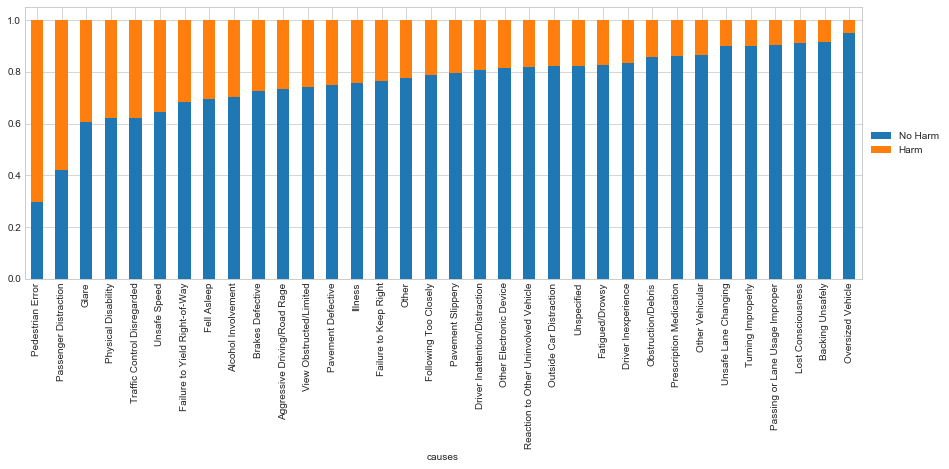

In [530]:
# causes that have high fatality rates 
data.groupby(['causes', 'fatality']).size().groupby(level = [0]).apply(lambda x: x / x.sum()).\
unstack().loc[fatal[fatal['fatality'] == 1].sort_values('perc', ascending = False).causes.values].\
plot(kind = 'bar', stacked = True, figsize = (15, 5))
plt.legend(labels = ['No Harm', 'Harm'], loc='center left', bbox_to_anchor=(1, 0.5))

In [399]:
top_fatal = fatal[fatal['fatality'] == 1].sort_values('perc', ascending = False).causes.iloc[0:5].values

In [407]:
fatal_yearmon = data[data['causes'].isin(top_fatal)].groupby(['causes', 'year', 'month', 'fatality']).size().\
groupby(level = [0, 1, 2]).apply(lambda x: x / x.sum()).rename('perc').reset_index()

Text(0.5,0,u'')

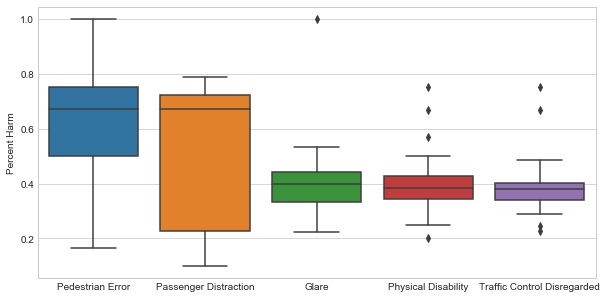

In [534]:
test = fatal_yearmon[(fatal_yearmon['fatality'] == 1)].set_index('causes').loc[top_fatal].reset_index()

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'causes', y = 'perc', data = test)
plt.ylabel('Percent Harm')
plt.xlabel('')

## Vehicle Type

In [418]:
vehicles = data.vehicle_type_code1.value_counts().cumsum()/data.shape[0]
top_ve = vehicles[vehicles <= 0.99].index

data.loc[:, 'vehicle'] = data['vehicle_type_code1']
data.loc[~data['vehicle'].isin(top_ve), 'vehicle'] = 'OTHER'

In [422]:
ves = data.groupby(['vehicle', 'fatality']).size().groupby(level = [0]).\
apply(lambda x: x / x.sum()).rename('perc').reset_index()

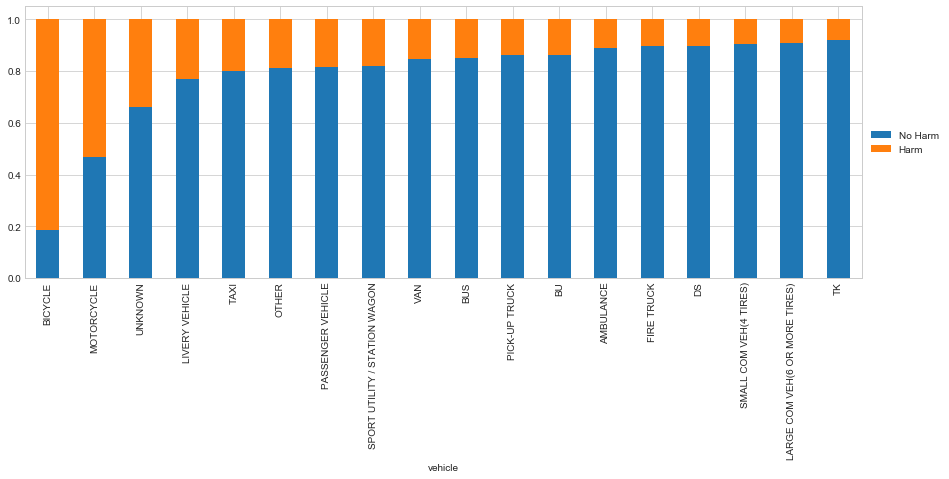

In [535]:
# top vehicles in injuries/deaths
data.groupby(['vehicle', 'fatality']).size().groupby(level = [0]).apply(lambda x: x / x.sum()).\
unstack().loc[ves[ves['fatality'] == 1].sort_values('perc', ascending = False).vehicle.values].plot(kind = 'bar', stacked = True, figsize = (15, 5))
plt.legend(labels = ['No Harm', 'Harm'], loc='center left', bbox_to_anchor=(1, 0.5))

## Times

In [234]:
fatal_times = data.groupby(['week', 'hour', 'fatality']).size().groupby(level = [0, 1]).apply(lambda x: x / x.sum()).rename('perc').reset_index()

Text(0.5,51,u'Hour of the Day')

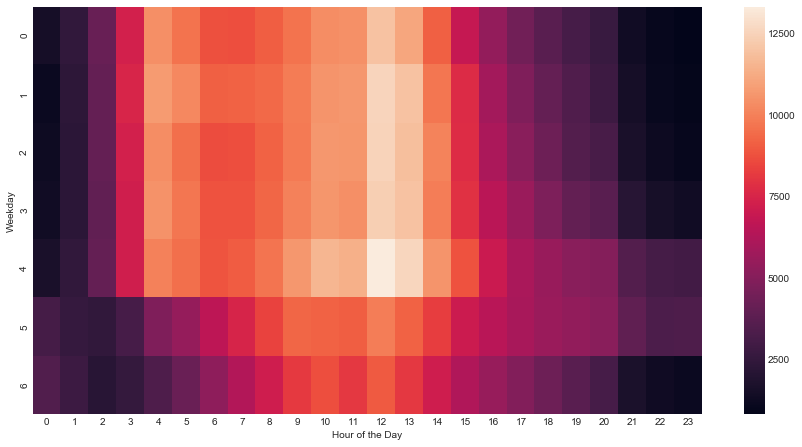

In [536]:
fig, ax = plt.subplots(figsize = (15, 7.5))
sns.heatmap(data.groupby(['week', 'hour']).size().unstack())
plt.ylabel('Weekday')
plt.xlabel('Hour of the Day')

Text(0.5,51,u'Hour of the Day')

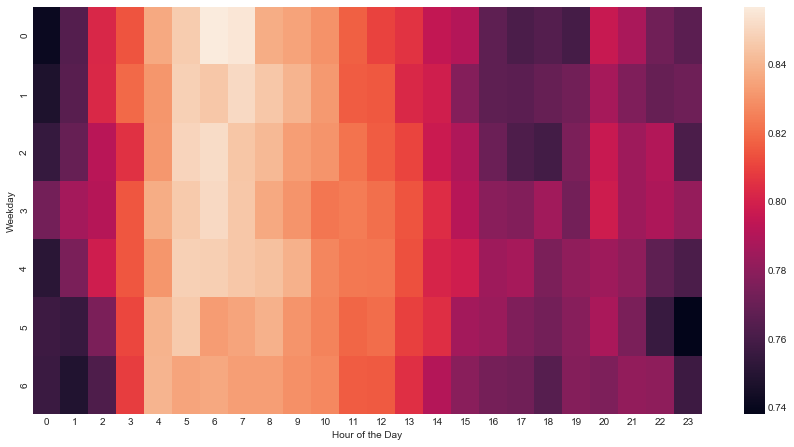

In [537]:
fig, ax = plt.subplots(figsize = (15, 7.5))
sns.heatmap(fatal_times.groupby(['week', 'hour']).perc.max().unstack())
plt.ylabel('Weekday')
plt.xlabel('Hour of the Day')

Text(0.5,0,u'')

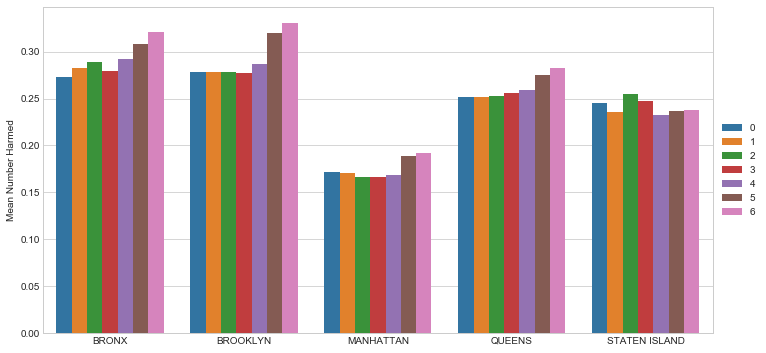

In [538]:
fatal_boro = data.groupby(['borough', 'week'])['num_fatality'].mean().rename('mean_fatality').reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'borough', y = 'mean_fatality', hue = 'week', data = fatal_boro)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Mean Number Harmed')
plt.xlabel('')

# Geo Viz

In [816]:
import folium

test = data[(data['fatality'] == 1) & (data['latitude'].notnull()) & (data['year'] == 2017) & (data['month'] == 9)]
locs = zip(test['latitude'], test['longitude'])

In [817]:
test = data[(data['fatality'] == 1) & (data['latitude'].notnull()) & (data['year'] == 2017) & (data['month'] == 9)]
locs = zip(test['latitude'], test['longitude'])

m = folium.Map(location=[40.738, -73.98], zoom_start=11)
for loc in locs[0:2000]:
    folium.CircleMarker(location=loc, color = 'red', radius = 1, fill = True, fill_opacity = 0.1).add_to(m)
m

In [960]:
test = data[(data['fatality'] == 1) & (data['latitude'].notnull()) & (data['vehicle'] == 'BICYCLE') & (data['year'] == 2017) & (data['month'] == 9)]
locs = zip(test['latitude'], test['longitude'])

m = folium.Map(location=[40.738, -73.98], zoom_start=11)
for loc in locs:
    folium.CircleMarker(location=loc, color = 'red', radius = 1, fill = True, fill_opacity = 0.1).add_to(m)
m

# Zip Code

In [832]:
zips_years = data.groupby('zip_code').year.nunique().rename('years').reset_index()

# investigate only zipcodes with 5 years of data
zips_accs = data[data['zip_code'].isin(zips_years[zips_years['years'] == 5].zip_code)].\
groupby(['zip_code', 'year']).size().rename('accidents').reset_index()

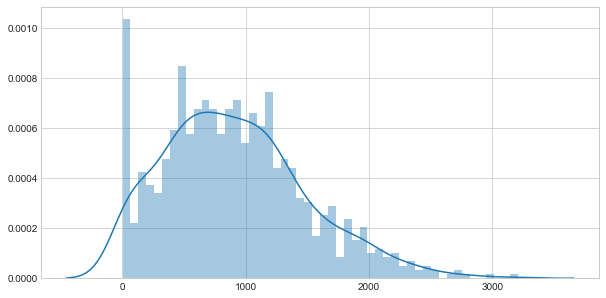

In [592]:
# distribution of accident volume over years --> follows normal
fig, ax = plt.subplots(figsize = (10, 5))
sns.distplot(zips_accs.accidents.values, bins = 50)

In [963]:
zips_accs.accidents.describe().reset_index().rename(columns = {'index' : 'statistic', 'accidents' : 'volume'})

,statistic,volume
0,count,920.000000
1,mean,912.317391
2,std,576.524565
3,min,1.000000
4,25%,486.750000
5,50%,858.000000
6,75%,1243.000000
7,max,3206.000000


In [596]:
zips_accs.accidents.quantile(0.1)

183.50000000000003

In [597]:
# remove bottom 10% of zipcodes with low accident counts
low_zips = zips_accs[zips_accs['accidents'] < zips_accs.accidents.quantile(0.1)].zip_code.unique()

In [630]:
# assume pop remains roughly the same 
zips = zips_accs[~zips_accs['zip_code'].isin(low_zips)]

In [631]:
zips_fatal = data[data['zip_code'].isin(zips['zip_code'])].groupby(['zip_code', 'year', 'fatality']).size().groupby(level = [0, 1]).\
apply(lambda x: x / x.sum()).rename('fatal_perc').reset_index()

In [632]:
zips.shape

(810, 3)

In [633]:
zips = pd.merge(zips, zips_fatal[zips_fatal['fatality'] == 1], on = ['zip_code', 'year'])

In [648]:
# calculate yoy % change in accident volume, fataility rate
zips.sort_values(['zip_code', 'year'], inplace = True)

zips['acc_shift'] = zips.groupby('zip_code')['accidents'].shift(1)
zips['fatal_shift'] = zips.groupby('zip_code')['fatal_perc'].shift(1)

zips['acc_perc_growth'] = (zips['accidents'] - zips['acc_shift'])/zips['acc_shift']
zips['fatal_perc_growth'] = (zips['fatal_perc'] - zips['fatal_shift'])/zips['fatal_shift']

yoy = zips.groupby('zip_code').agg({'acc_perc_growth' : 'mean', 'fatal_perc_growth' : 'mean'}).reset_index()

In [634]:
from scipy.stats import linregress
def regress(grp, col):
    return linregress(grp.year, grp[col])[0]

In [638]:
def prepare_descrip(df):
    # determine trends (accidents, fatality rate) for each zip code 
    df_trend = df.groupby('zip_code').apply(regress, 'accidents').rename('acc_mo').reset_index().set_index('zip_code')
    df_trend['fatal_mo'] = df.groupby('zip_code').apply(regress, 'fatal_perc').reset_index().set_index('zip_code')
    
    df_stats = df.loc[:, ['zip_code', 'accidents', 'fatal_perc']].groupby('zip_code').agg(['mean', 'median', 'std'])
    df_stats.columns = ['_'.join(col).strip() for col in df_stats.columns.values]
    
    df_final = pd.concat([df_stats, df_trend], axis = 1)
    
    return df_final

In [639]:
stats = prepare_descrip(zips).reset_index()

In [640]:
stats.corr()

,zip_code,accidents_mean,accidents_median,accidents_std,fatal_perc_mean,fatal_perc_median,fatal_perc_std,acc_mo,fatal_mo
zip_code,1.000000,-0.012051,-0.017575,-0.157870,0.408356,0.413514,0.096407,0.240132,0.043347
accidents_mean,-0.012051,1.000000,0.997433,0.495651,0.040034,0.028065,-0.343473,0.061212,-0.077113
accidents_median,-0.017575,0.997433,1.000000,0.477664,0.019974,0.010230,-0.356077,0.030314,-0.061413
accidents_std,-0.157870,0.495651,0.477664,1.000000,0.088208,0.057903,-0.047262,0.078885,-0.101875
fatal_perc_mean,0.408356,0.040034,0.019974,0.088208,1.000000,0.987973,0.408315,0.501479,-0.402470
fatal_perc_median,0.413514,0.028065,0.010230,0.057903,0.987973,1.000000,0.366949,0.468213,-0.348967
fatal_perc_std,0.096407,-0.343473,-0.356077,-0.047262,0.408315,0.366949,1.000000,0.300539,-0.327685
acc_mo,0.240132,0.061212,0.030314,0.078885,0.501479,0.468213,0.300539,1.000000,-0.437577
fatal_mo,0.043347,-0.077113,-0.061413,-0.101875,-0.402470,-0.348967,-0.327685,-0.437577,1.000000


In [669]:
final = pd.merge(stats, yoy, on = 'zip_code')

In [674]:
# all meterics positive --> bad
bads = final[(final['acc_mo'] > 0)&(final['fatal_mo'] > 0)&(final['acc_perc_growth'] > 0)&(final['fatal_perc_growth'] > 0)]

In [964]:
bads_metrics = bads[['zip_code', 'acc_mo', 'fatal_mo', 'acc_perc_growth', 'fatal_perc_growth']].sort_values(['acc_mo', 'fatal_mo'], ascending = [False, False])
bads_metrics.columns = ['zip_code', 'collision_momen', 'fatality_rate_momen', 'collision_mean_yoy', 'fatality_rate_mean_yoy']

In [978]:
data[data['zip_code'].isin(bads['zip_code'])].groupby(['borough']).zip_code.nunique().\
sort_values(ascending = False).reset_index().rename(columns = {'zip_code' : 'number_zips'})

,borough,number_zips
0,QUEENS,19
1,BRONX,4
2,BROOKLYN,3
3,STATEN ISLAND,2
4,MANHATTAN,2


In [ ]:
#json nyc zipcode geo map

import json
zip_geo = json.load(open('zip.json'))

In [853]:
zip_geo1['features'][0]['properties']

{u'@id': u'http://nyc.pediacities.com/Resource/PostalCode/11372',
 u'BLDGpostalCode': 0,
 u'CTY_FIPS': u'081',
 u'OBJECTID': 1,
 u'PO_NAME': u'Jackson Heights',
 u'STATE': u'NY',
 u'ST_FIPS': u'36',
 u'Shape_Area': 20163283.8744,
 u'Shape_Leng': 20624.6923165,
 u'borough': u'Queens',
 'highlight': {'fillOpacity': 0.8, 'weight': 3},
 u'postalCode': u'11372',
 'style': {'color': 'black',
  'fillColor': '#fc4e2a',
  'fillOpacity': 0.6,
  'opacity': 1,
  'weight': 1}}

In [859]:
neigh_map = pd.Series({x['properties']['postalCode'] : x['properties']['PO_NAME'] for x in zg['features']}).to_dict()

In [1000]:
info = final[['zip_code', 'fatal_mo']]
info['zip_code'] = info['zip_code'].astype(int).apply(lambda x: str(x))

/Users/peterli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [997]:
# map of mean fatality rate over 5 years
m = folium.Map(location=[40.738, -73.98], zoom_start=11)
m.choropleth(zip_geo, data = dict(zip(info['zip_code'], info['fatal_perc_mean'])),
             columns = ['zip_code', 'fatal_perc_mean'], 
             key_on = 'feature.properties.postalCode',
            fill_color = 'YlOrRd', highlight = True) 
m

In [1001]:
# map of mean fatality momentum over 5 years
m = folium.Map(location=[40.738, -73.98], zoom_start=11)
m.choropleth(zip_geo, data = dict(zip(info['zip_code'], info['fatal_mo'])),
             columns = ['zip_code', 'fatal_mo'], 
             key_on = 'feature.properties.postalCode',
            fill_color = 'YlOrRd', highlight = True) 
m